# Country-wise comparison

Initially just with Australia as they handled COVID relatively similar to New Zealand. Just for 2020 and 2021.

In [1]:
import os
import re
import csv
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
headers = [
    'gkg_id', 'date', 'source', 'source_name', 'doc_id', 
    'themes', 'locations', 'persons', 'orgs', 
    'tone', 'pos', 'neg', 'polarity', 'ard', 'srd',
    'wc', 
    'lexicode_neg', 'lexicode_pos', # c3.*
    'MACROECONOMICS', 'ENERGY', 'FISHERIES', 
    'TRANSPORTATION', 'CRIME', 'SOCIAL_WELFARE',
    'HOUSING', 'FINANCE', 'DEFENCE', 'SSTC',
    'FOREIGN_TRADE', 'CIVIL_RIGHTS', 
    'INTL_AFFAIRS', 'GOVERNMENT_OPS',
    'LAND-WATER-MANAGEMENT', 'CULTURE',
    'PROV_LOCAL', 'INTERGOVERNMENTAL',
    'CONSTITUTIONAL_NATL_UNITY', 'ABORIGINAL',
    'RELIGION', 'HEALTHCARE', 'AGRICULTURE',
    'FORESTRY', 'LABOUR', 'IMMIGRATION',
    'EDUCATION', 'ENVIRONMENT',
    'finstab_pos', 'finstab_neg', 'finstab_neutral',
    'finsent_neg', 'finsent_pos', 'finsent_unc',
    'opin_neg', 'opin_pos',
    'sent_pos', 'sent_neg', 'sent_pol'
]

In [3]:
country_to_folder = { 
    'nz': "processed_gdelt2",
    'au': "processed_gdelt2_au",
    'ca': "processed_gdelt2_ca"
}
    
nz_files_20_21 = [f"processed_gdelt2/{file}" 
                  for file in os.listdir("processed_gdelt2")
                  if re.search(r'202[0-1]\d{10}.gkg.csv', file)]
au_files_20_21 = [f"processed_gdelt2_au/{file}" 
                  for file in os.listdir("processed_gdelt2_au")
                  if re.search(r'202[0-1]\d{10}.gkg.csv', file)]

def get_2020_and_2021_files(country):
    return [os.path.join(country_to_folder[country], file)
            for file in os.listdir(country_to_folder[country])
            if re.search(r'202[0-1]\d{10}.gkg.csv', file)]

ca_files_20_21 = get_2020_and_2021_files("ca")

In [4]:
def merge_csvs(mergefile, infpaths, overwrite=False):
    if os.path.exists(mergefile) and not overwrite:
        return
    
    with open(mergefile, 'w', newline="") as outfile:
        outwriter = csv.writer(outfile, delimiter=',')
        outwriter.writerow(headers)
        for fpath in infpaths:
            with open(fpath) as infile:
                inwriter = csv.reader(infile, delimiter=',')
                outwriter.writerows(inwriter)

In [5]:
%%time
merge_csvs('gdelt-nz-20-21.csv', nz_files_20_21)

CPU times: user 0 ns, sys: 336 µs, total: 336 µs
Wall time: 235 µs


In [6]:
%%time
merge_csvs('gdelt-au-20-21.csv', au_files_20_21)

CPU times: user 46 µs, sys: 15 µs, total: 61 µs
Wall time: 40.1 µs


In [7]:
%%time
merge_csvs('gdelt-ca-20-21.csv', ca_files_20_21)

CPU times: user 53 µs, sys: 0 ns, total: 53 µs
Wall time: 56 µs


In [8]:
# %%time    
# gdelt_nz = pd.read_csv("gdelt-nz-20-21.csv")
# gdelt_au = pd.read_csv("gdelt-au-20-21.csv")

# gdelt = dict()
# for country in ['nz', 'au', 'ca']:
#     gdelt[country] = pd.read_csv(f"gdelt-{country}-20-21.csv")

# LOADING THE THREE COUNTRIES INTO DATAFRAMES EXCEEDS RAM

In [9]:
countries = ['nz', 'au', 'ca']

**Loading the merged CSV files for New Zealand, Australia, and Canada exceeds the available RAM so jupyter crashes.**

In [10]:
def get_time_aggregated_dfs(country_code):
    """
    Returns four DataFrames for the given country
    - daily_tone: tone, pos, neg (daily)
    - weekly_tone: tone, pos, neg (weekly)
    - daily_count: number of articles (daily)
    - weekly_count: number of articles (weekly)
    """
    gdelt = pd.read_csv(f"gdelt-{country_code}-20-21.csv")
    print(country_code, "read")
    
    gdelt['date'] = pd.to_datetime(gdelt['date'], format="%Y%m%d%H%M%S")
    gdelt = gdelt.sort_values(by=["gkg_id"]).reset_index()
    print(country_code, "tidied")
    
    daily = gdelt.resample('D', on='date')[['tone', 'pos', 'neg']].mean()
    weekly = gdelt.resample('W-Mon', on='date')[['tone', 'pos', 'neg']].mean()
    daily_count = gdelt.resample('D', on='date')['gkg_id'].count()
    weekly_count = gdelt.resample('W-Mon', on='date')['gkg_id'].count()
    print(country_code, "compiled")
    
    return daily, weekly, daily_count, weekly_count

In [11]:
%%time
nz_dfs = get_time_aggregated_dfs('nz')
au_dfs = get_time_aggregated_dfs('au')
ca_dfs = get_time_aggregated_dfs('ca')

nz read
nz tidied
nz compiled
au read
au tidied
au compiled
ca read
ca tidied
ca compiled
CPU times: user 2min 38s, sys: 17.9 s, total: 2min 56s
Wall time: 3min 17s


In [12]:
tone_columns = pd.MultiIndex.from_product([countries, ['tone', 'pos', 'neg']])

daily_tone = pd.concat([nz_dfs[0], au_dfs[0], ca_dfs[0]], axis=1)
daily_tone.columns = tone_columns

weekly_tone = pd.concat([nz_dfs[1], au_dfs[1], ca_dfs[1]], axis=1)
weekly_tone.columns = tone_columns

daily_tone.head()

nz                            au                      \
                tone       pos       neg      tone       pos       neg   
date                                                                     
2020-01-01 -1.893036  2.538070  4.431106 -1.784209  2.527945  4.312154   
2020-01-02 -0.917254  2.633725  3.550979 -1.522902  2.598995  4.121897   
2020-01-03 -2.359937  2.334887  4.694824 -2.257253  2.426037  4.683289   
2020-01-04 -1.413238  2.398179  3.811417 -2.242837  2.633002  4.875839   
2020-01-05 -2.388716  2.206049  4.594766 -2.544602  2.346158  4.890760   

                  ca                      
                tone       pos       neg  
date                                      
2020-01-01 -0.411786  2.823087  3.234873  
2020-01-02 -0.195858  2.853322  3.049180  
2020-01-03 -0.412256  2.714964  3.127221  
2020-01-04 -1.136813  2.555905  3.692719  
2020-01-05 -1.437621  2.573264  4.010886

In [13]:
daily_tone_long = daily_tone.xs('tone', axis=1, level=1) \
                            .reset_index() \
                            .melt("date",
                                  var_name="country", 
                                  value_name="tone", 
                                  value_vars=['nz','au','ca'])
weekly_tone_long = weekly_tone.xs('tone', axis=1, level=1) \
                              .reset_index() \
                              .melt("date",
                                    var_name="country", 
                                    value_name="tone", 
                                    value_vars=['nz','au','ca'])

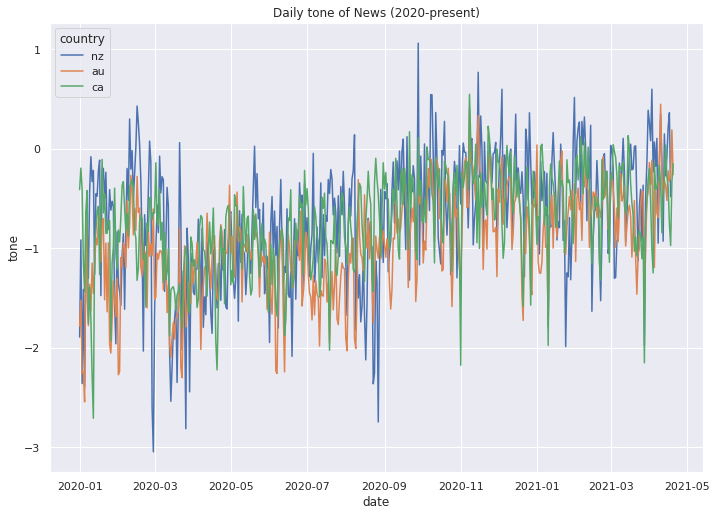

In [28]:
g = sns.lineplot(data=daily_tone_long, x="date", y="tone", hue="country")
g.set(title="Daily tone of News (2020-present)");

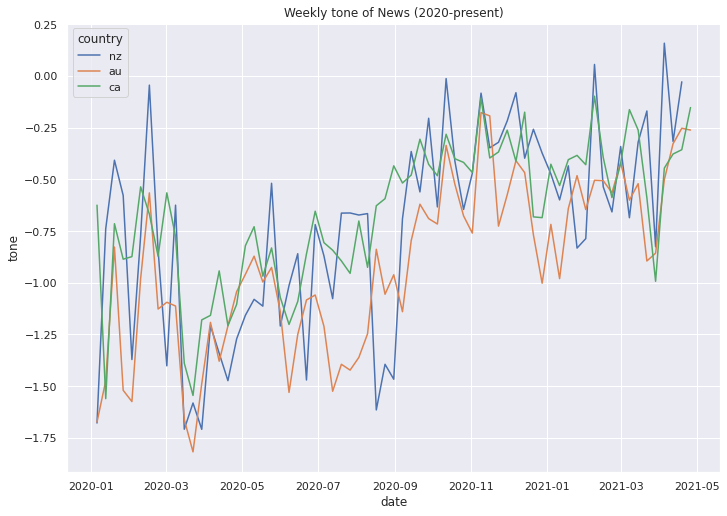

In [32]:
g = sns.lineplot(data=weekly_tone_long, x="date", y="tone", hue="country")
g.set(title="Weekly tone of News (2020-present)");

In [33]:
daily_count = pd.concat({'nz': nz_dfs[2], 'au': au_dfs[2], 'ca': ca_dfs[2]}, axis=1)
weekly_count = pd.concat({'nz': nz_dfs[3], 'au': au_dfs[3], 'ca': ca_dfs[3]}, axis=1)

daily_count_long = daily_count.reset_index() \
                              .melt("date",
                                    var_name="country", 
                                    value_name="num_articles", 
                                    value_vars=['nz','au','ca'])
weekly_count_long = weekly_count.reset_index() \
                                .melt("date",
                                      var_name="country", 
                                      value_name="num_articles", 
                                      value_vars=['nz','au','ca'])

In [34]:
daily_count_long

,date,country,num_articles
0,2020-01-01,nz,2182.0
1,2020-01-02,nz,1795.0
2,2020-01-03,nz,2114.0
3,2020-01-04,nz,1332.0
4,2020-01-05,nz,1580.0
...,...,...,...
1423,2021-04-16,ca,6867.0
1424,2021-04-17,ca,3796.0
1425,2021-04-18,ca,3005.0
1426,2021-04-19,ca,5817.0


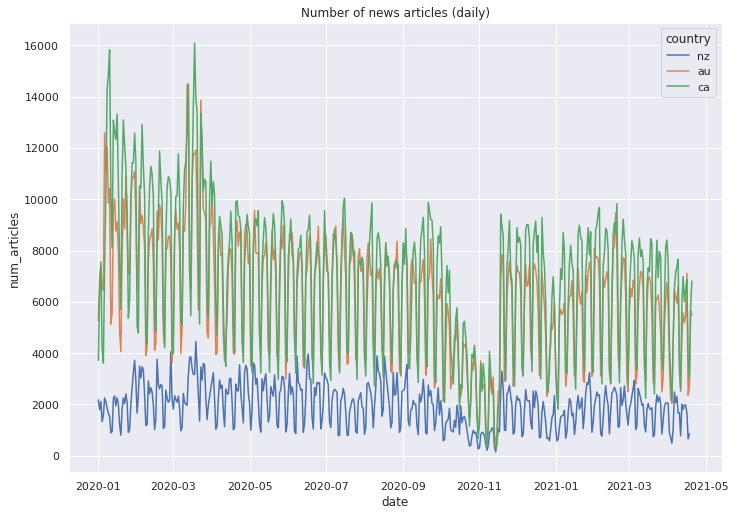

In [35]:
g = sns.lineplot(data=daily_count_long, x="date", y="num_articles", hue="country")
g.set(title="Number of news articles (daily)");

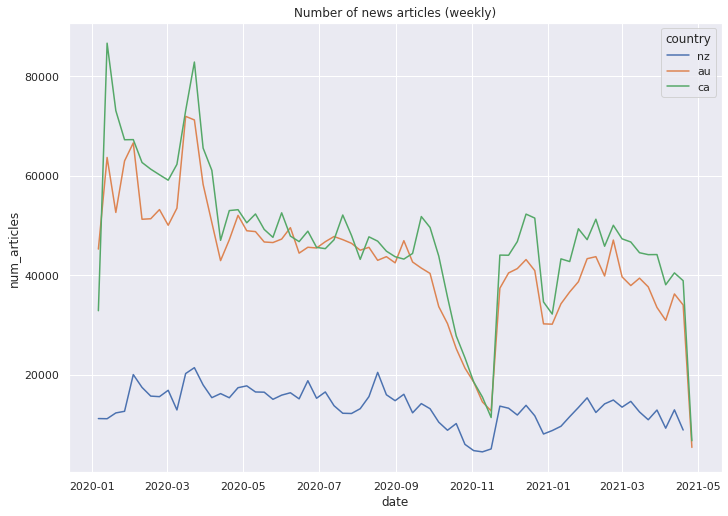

In [36]:
g = sns.lineplot(data=weekly_count_long, x="date", y="num_articles", hue="country")
g.set(title="Number of news articles (weekly)");

## Verify that seasonality is weekly

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [38]:
daily_count.index.strftime("%b %y")
['Jan 20', 'Mar 20', 'Jul 20', 'Oct 20', 'Jan 21', 'Mar 21']

['Jan 20', 'Mar 20', 'Jul 20', 'Oct 20', 'Jan 21', 'Mar 21']

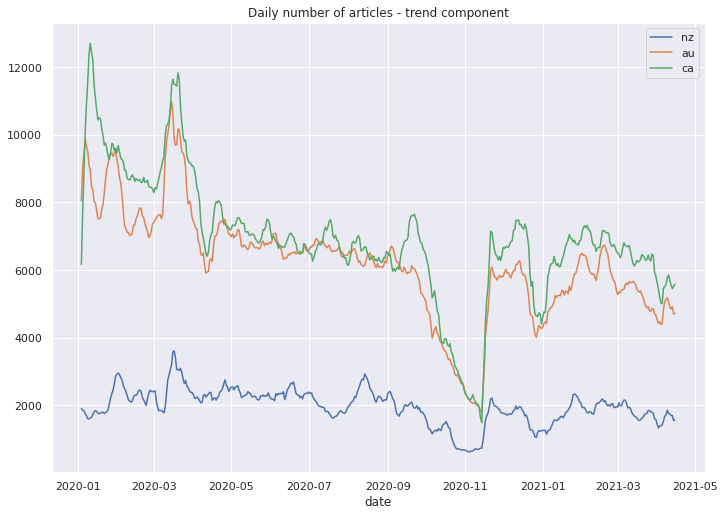

In [39]:
tone_trends = pd.concat({
    country: seasonal_decompose(daily_count.dropna()[country],
                                model='additive'
                                ).trend
    for country in countries
}, axis=1)

g = sns.lineplot(data=tone_trends, dashes=False)
g.set(title="Daily number of articles - trend component");

In [40]:
daily_count['Day'] = daily_count.index.day_name().astype("category").reorder_categories(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
first_monday = daily_count[daily_count['Day'] == "Monday"].index[0]
first_monday_idx = (first_monday - datetime(2020, 1, 1)).days

first_monday, first_monday_idx

(Timestamp('2020-01-06 00:00:00', freq='7D'), 5)

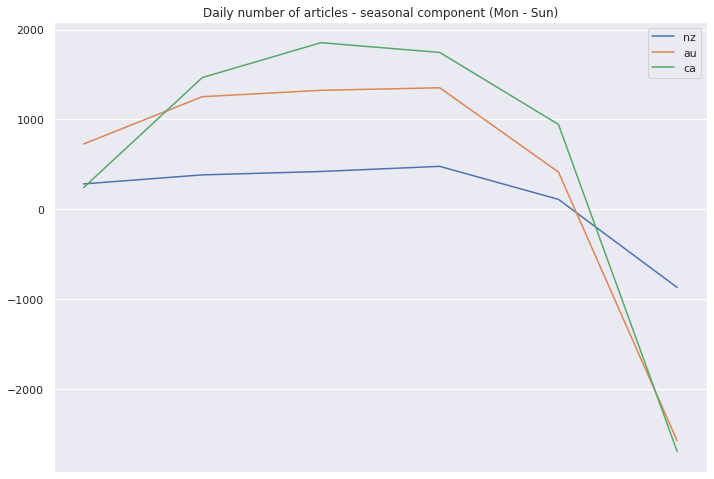

In [41]:
tone_seasonals = pd.concat({
    country: seasonal_decompose(daily_count.dropna()[country],#, 'tone'], 
                                model='additive'
                                ).seasonal[first_monday_idx:(first_monday_idx+6)]
    for country in countries
}, axis=1)

g = sns.lineplot(data=tone_seasonals, dashes=False)
g.set(title="Daily number of articles - seasonal component (Mon - Sun)",
      xticks=[], xlabel='');